In [1]:
import cv2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [3]:
img = cv2.imread("../collection/category/0100.jpg")

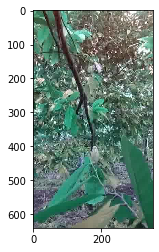

In [4]:
plt.imshow(img)

### HSV PLOT for analysis

In [5]:
hsv_nemo = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [7]:
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

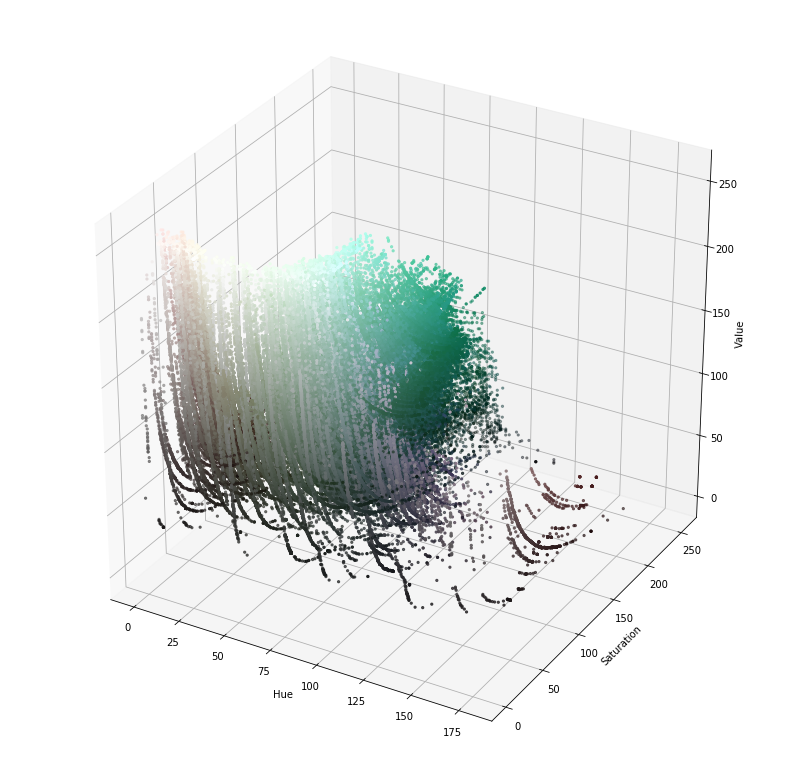

In [8]:
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(14,14))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

### K-means

In [9]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = img.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [10]:
print(pixel_values.shape)

(225280, 3)


In [11]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [12]:
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [13]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [14]:
segmented_image = centers[labels.flatten()]

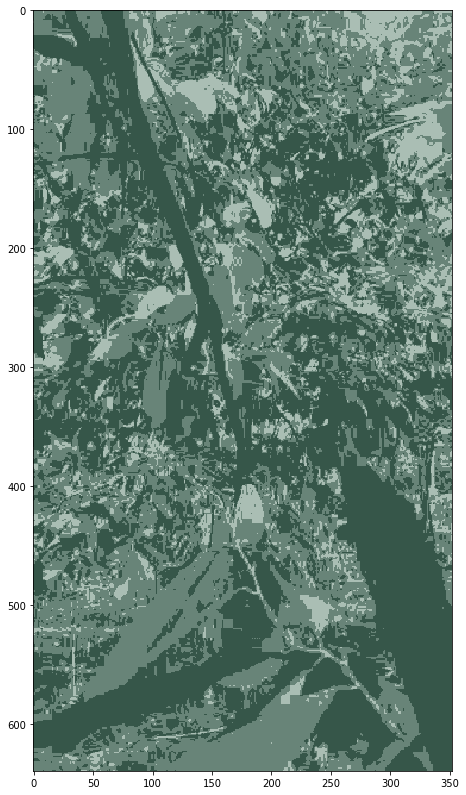

In [15]:
segmented_image = segmented_image.reshape(img.shape)
# show the image
plt.figure(figsize=(14,14))
plt.imshow(segmented_image)

### Some segmentation results

In [20]:
image_slic = seg.slic(img,n_segments=200)

/Users/raunaq/Documents/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


/Users/raunaq/Documents/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """Entry point for launching an IPython kernel.


(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1328b1990>)

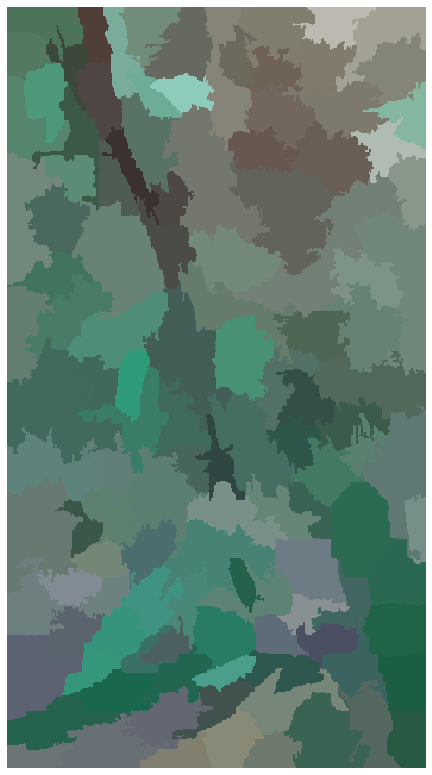

In [21]:
image_show(color.label2rgb(image_slic, img, kind='avg'))

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137ce8310>)

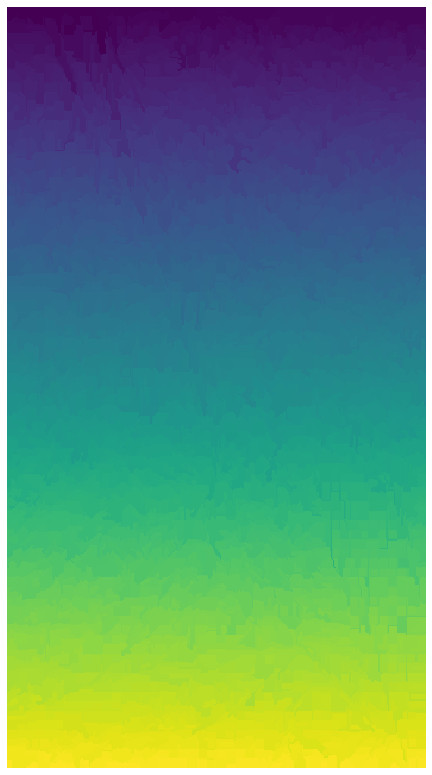

In [22]:
image_show(seg.felzenszwalb(img))

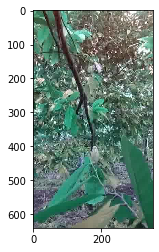

In [23]:
plt.imshow(img)

### Thresholding results

In [18]:
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/thresh.cpp:1529: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'threshold'


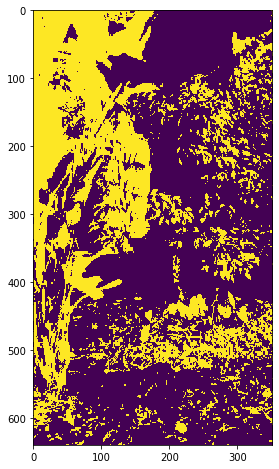

In [25]:
plt.figure(figsize=(12,8))
plt.imshow(th2)

In [19]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image)
    ax.axis('off')
    return fig, ax

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1361419d0>)

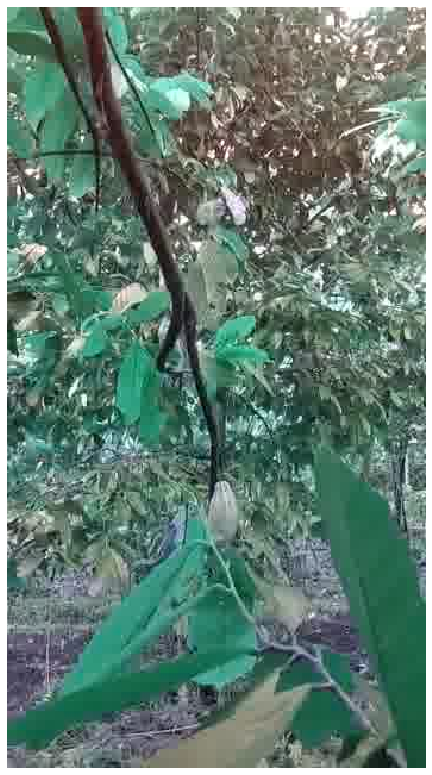

In [24]:
image_show(img)

### Color bining

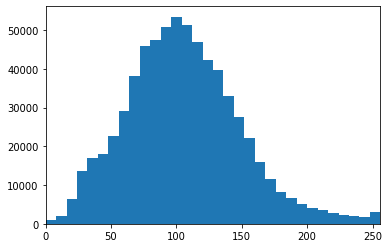

In [25]:
fig, ax = plt.subplots(1, 1)
ax.hist(img.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

In [26]:
binary = img > filters.threshold_li(img)

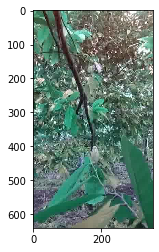

In [27]:
plt.imshow(img)

### Gradients

In [30]:
img = cv2.imread("../collection/category/0100.jpg")

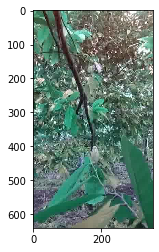

In [31]:
plt.imshow(img)

In [32]:
src = cv2.GaussianBlur(img, (3, 3), 0)
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

In [33]:
laplacian = cv2.Laplacian(src_gray,cv2.CV_64F,3)

In [34]:
abs_dst = cv2.convertScaleAbs(laplacian)

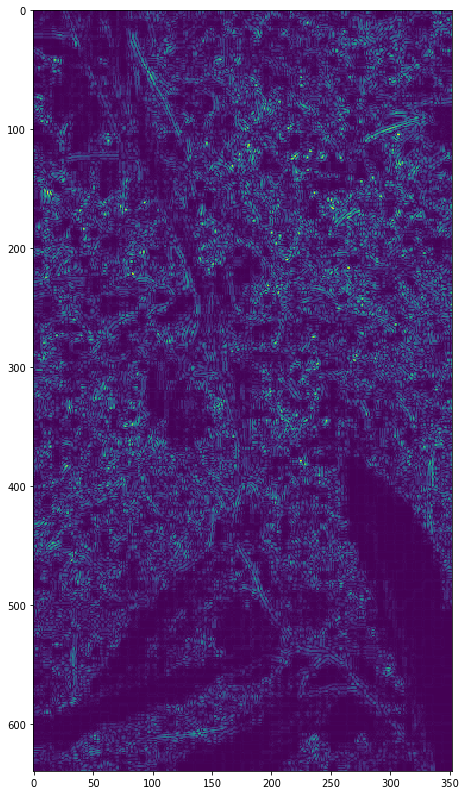

In [35]:
plt.figure(figsize=(14,14))
plt.imshow(abs_dst)

## Sobel Filters

In [36]:
# Gradient-X
scale = 1
delta = 0
ddepth = cv2.CV_64F
grad_x = cv2.Sobel(src_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
grad_y = cv2.Sobel(src_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

In [37]:
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)


grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

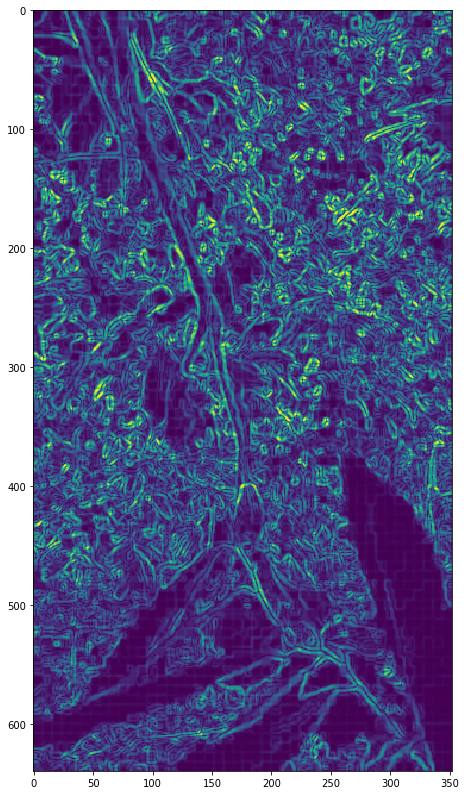

In [38]:
plt.figure(figsize=(14,14))
plt.imshow(grad)

#### Watershed segmentation

In [39]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
src = cv2.GaussianBlur(img, (3, 3), 0)
imgLaplacian = cv2.filter2D(src, cv2.CV_64F, kernel)

sharp = np.float32(src)
imgResult = sharp - imgLaplacian

In [40]:
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#cv.imshow('Laplace Filtered Image', imgLaplacian)


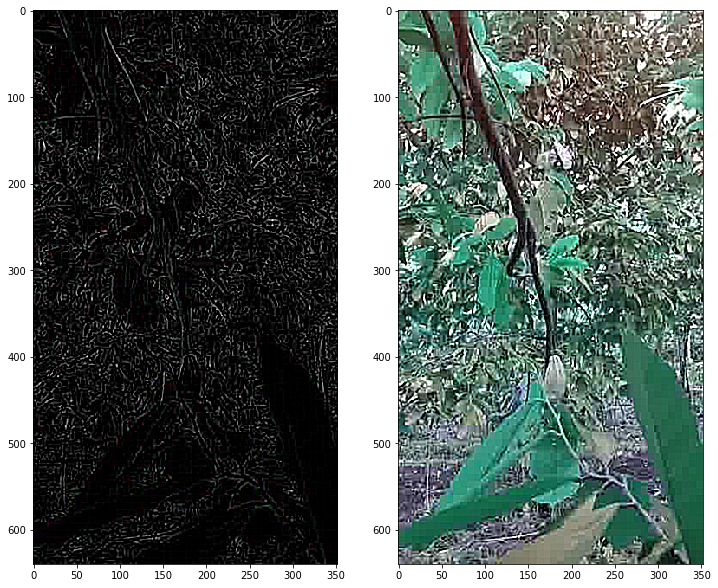

In [41]:
f, axarr = plt.subplots(1,2, figsize=(12,14))
axarr[0].imshow(imgLaplacian)
axarr[1].imshow(imgResult)

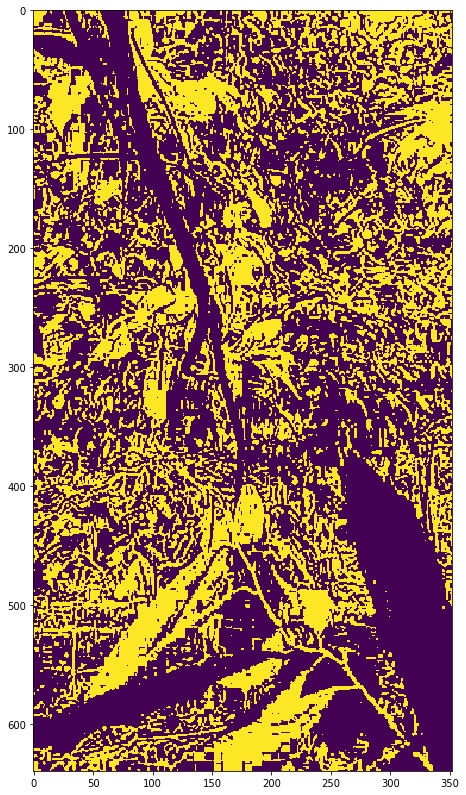

In [42]:
bw = cv2.cvtColor(imgResult, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.figure(figsize=(12,14))
plt.imshow(bw)

#### Distance Transform
The distance transform operator generally takes binary images as inputs. In this operation, the gray level intensities of the points inside the foreground regions are changed to distance their respective distances from the closest 0 value (boundary).

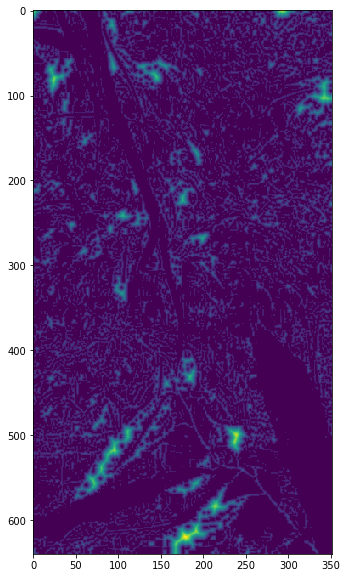

In [43]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.figure(figsize=(10,10))
plt.imshow(dist)

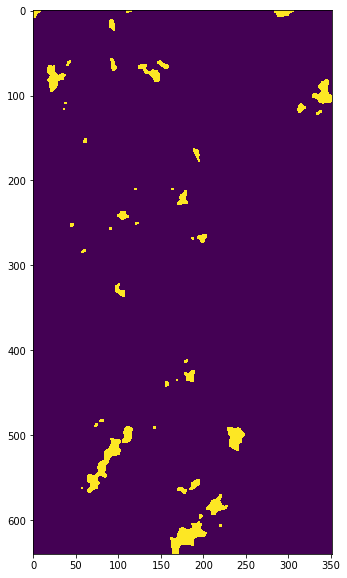

In [44]:
# Threshold and then dilate to obtain the peaks
# This will be the markers for the foreground objects

_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.figure(figsize=(10,10))
plt.imshow(dist)

Text(0.5, 1.0, 'Markers')

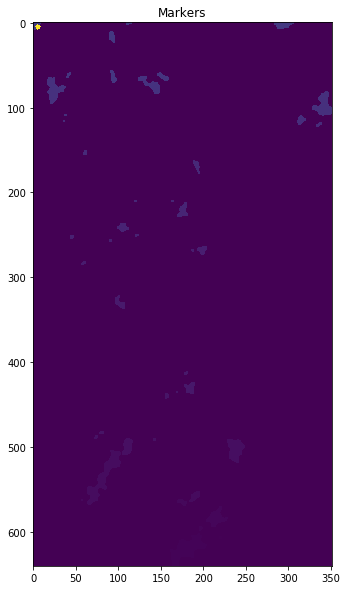

In [45]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
plt.figure(figsize=(10,10))
plt.imshow(markers*10000)
plt.title("Markers")

In [46]:
import random as rng

Text(0.5, 1.0, 'Final Result')

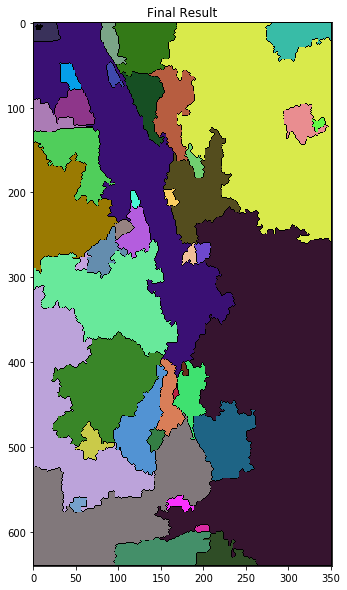

In [47]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.figure(figsize=(10,10))
plt.imshow(dst)
plt.title('Final Result')